In [1]:
import os
os.chdir('../')
from pathlib import Path

import itertools
import pandas as pd

from src.features.comparison_utils import get_country_statistics, compare_two_countries

from src.visualization.plot_utils import plot_effect_types

from src.features.covid_spread_utils import get_max_covid_corr
import notebooks.config as experim_cfg

In [2]:
data_path = Path('data', 'external', 'owid-covid-data.csv')
covid_data = pd.read_csv(data_path, index_col=0)
covid_data = covid_data[~covid_data.iso_code.str.contains('OWID')]
covid_data['date'] = covid_data['date'].astype('datetime64')

unique_countries_stats_path = Path(
    'data',
    'interim',
    f'unique_countries_({experim_cfg.MORTALITY_INDICATOR}).csv',
)
unique_countries = pd.read_csv(unique_countries_stats_path, index_col=0)

# Selecting several countries to compare

## Filter initial data for comparison

In [3]:
# Compute vaccination start date
first_vac_index = covid_data[
    ~covid_data.people_vaccinated.isna()
]
vac_start_date_mapper = first_vac_index.groupby(['iso_code'])['date'].first()

# Compute covid start date
first_covid_index = covid_data[
    ~covid_data.total_cases.isna()
]
covid_start_date_mapper = first_covid_index.groupby(['iso_code'])['date'].first()

# corr_quadrant
corr_quadrant_mapper = unique_countries.set_index('iso_code')['corr_quadrant']

# cluster
cluster_mapper = unique_countries.set_index('iso_code')['cluster']

covid_df_for_DID = covid_data[covid_data.iso_code.isin(unique_countries.iso_code)].copy()

covid_df_for_DID['covid_start_date'] = covid_df_for_DID['iso_code'].map(covid_start_date_mapper)
covid_df_for_DID['vac_start_date'] = covid_df_for_DID['iso_code'].map(vac_start_date_mapper)
covid_df_for_DID['corr_quadrant'] = covid_df_for_DID['iso_code'].map(corr_quadrant_mapper)
covid_df_for_DID['cluster'] = covid_df_for_DID['iso_code'].map(cluster_mapper)

In [4]:
covid_df_for_DID_path = Path(
    'data',
    'interim',
    f'covid_df_for_DID_({experim_cfg.MORTALITY_INDICATOR}).csv',
)
covid_df_for_DID.to_csv(covid_df_for_DID_path, index=False)

## Computing final comparison dataframe

In [5]:
# Compute DID parameters for all countries
all_countries_stats = {}
for index, country in enumerate(covid_df_for_DID.iso_code.unique()):
    country_stats = get_country_statistics(
        iso_code=country,
        covid_df=covid_df_for_DID,
        mortality_indicator=experim_cfg.MORTALITY_INDICATOR,
    )
    all_countries_stats[index] = country_stats
all_countries_stats = pd.DataFrame(all_countries_stats).T

countries_stats_path = Path(
    'data',
    'interim',
    f'all_countries_stats({experim_cfg.MORTALITY_INDICATOR}).csv',
)
all_countries_stats.to_csv(countries_stats_path, index=False)

In [6]:
all_countries_comparisons = {}
for iteration, product in enumerate(itertools.combinations(all_countries_stats.iso_code.unique(), 2)):
    country_comparison = compare_two_countries(
        iso_code_1=product[0],
        iso_code_2=product[1],
        full_stats_df=all_countries_stats,
    )
    all_countries_comparisons[iteration] = country_comparison
all_countries_comparisons = pd.DataFrame(all_countries_comparisons).T

In [7]:
comparisons_stats_path = Path(
    'data',
    'processed',
    f'all_counties_comparisons({experim_cfg.MORTALITY_INDICATOR}).csv',
)
all_countries_comparisons.to_csv(comparisons_stats_path, index=False)

## Consideing results

In [8]:
all_countries_comparisons.shape

(2145, 51)

In [9]:
sorted(all_countries_comparisons.columns)

['DID_10%_vac-120d_BV',
 'DID_10%_vac-150d_BV',
 'DID_10%_vac-90d_BV',
 'DID_25%_vac-120d_BV',
 'DID_25%_vac-150d_BV',
 'DID_25%_vac-90d_BV',
 'DID_50%_vac-120d_BV',
 'DID_50%_vac-150d_BV',
 'DID_50%_vac-90d_BV',
 'DID_EM_AV-BV',
 'DID_EM_AV_BDS-BV',
 'VacRate_effect_10%_vac-120d_BV',
 'VacRate_effect_10%_vac-150d_BV',
 'VacRate_effect_10%_vac-90d_BV',
 'VacRate_effect_25%_vac-120d_BV',
 'VacRate_effect_25%_vac-150d_BV',
 'VacRate_effect_25%_vac-90d_BV',
 'VacRate_effect_50%_vac-120d_BV',
 'VacRate_effect_50%_vac-150d_BV',
 'VacRate_effect_50%_vac-90d_BV',
 'VacRate_effect_EM_AV-BV',
 'VacRate_effect_EM_AV_BDS-BV',
 'Vac_effect_10%_vac-120d_BV',
 'Vac_effect_10%_vac-150d_BV',
 'Vac_effect_10%_vac-90d_BV',
 'Vac_effect_25%_vac-120d_BV',
 'Vac_effect_25%_vac-150d_BV',
 'Vac_effect_25%_vac-90d_BV',
 'Vac_effect_50%_vac-120d_BV',
 'Vac_effect_50%_vac-150d_BV',
 'Vac_effect_50%_vac-90d_BV',
 'Vac_effect_EM_AV-BV',
 'Vac_effect_EM_AV_BDS-BV',
 'delta_covid_start_date',
 'delta_days_to_10%',


In [10]:
all_countries_comparisons.filter(like='effect').apply(
    pd.Series.value_counts,
    dropna=False,
    normalize=True,
).T.sort_index().fillna(0).round(3)

bad   diff   good    NaN
VacRate_effect_10%_vac-120d_BV  0.497  0.000  0.503  0.000
VacRate_effect_10%_vac-150d_BV  0.490  0.000  0.510  0.000
VacRate_effect_10%_vac-90d_BV   0.504  0.000  0.496  0.000
VacRate_effect_25%_vac-120d_BV  0.466  0.000  0.503  0.030
VacRate_effect_25%_vac-150d_BV  0.479  0.000  0.491  0.030
VacRate_effect_25%_vac-90d_BV   0.473  0.000  0.497  0.030
VacRate_effect_50%_vac-120d_BV  0.331  0.000  0.287  0.382
VacRate_effect_50%_vac-150d_BV  0.333  0.000  0.285  0.382
VacRate_effect_50%_vac-90d_BV   0.331  0.000  0.287  0.382
VacRate_effect_EM_AV-BV         0.474  0.000  0.526  0.000
VacRate_effect_EM_AV_BDS-BV     0.452  0.000  0.548  0.000
Vac_effect_10%_vac-120d_BV      0.140  0.478  0.382  0.000
Vac_effect_10%_vac-150d_BV      0.164  0.491  0.345  0.000
Vac_effect_10%_vac-90d_BV       0.129  0.470  0.401  0.000
Vac_effect_25%_vac-120d_BV      0.164  0.478  0.328  0.030
Vac_effect_25%_vac-150d_BV      0.176  0.483  0.310  0.030
Vac_effect_25%_vac-90d_BV       0.164  0.478  0.328  0.030
Vac_effect_50%_vac-120d_BV      0.108  0.308  0.203  0.382
Vac_effect_50%_vac-150d_BV      0.118  0.311  0.189  0.382
Vac_effect_50%_vac-90d_BV       0.089  0.298  0.231  0.382
Vac_effect_EM_AV-BV             0.462  0.441  0.098  0.000
Vac_effect_EM_AV_BDS-BV         0.526  0.403  0.071  0.000

<Figure size 720x720 with 0 Axes>

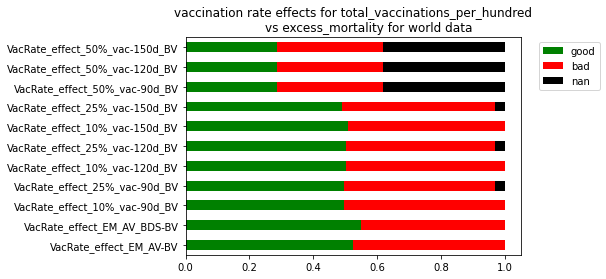

In [11]:
plot_effect_types(
    comparison_df=all_countries_comparisons,
    effect_type='vaccination rate',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)

<Figure size 720x720 with 0 Axes>

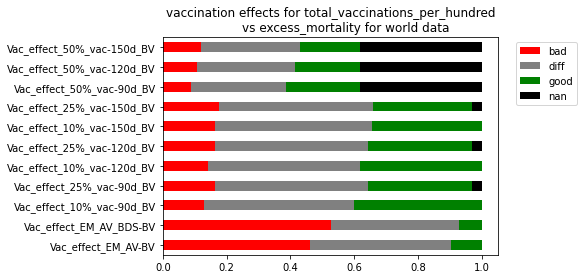

In [12]:
plot_effect_types(
    comparison_df=all_countries_comparisons,
    effect_type='vaccination',
    vaccination_indicator=experim_cfg.VACCINATION_INDICATOR,
    mort_indicator=experim_cfg.MORTALITY_INDICATOR,
)